# Machine Learning Engineer Nanodegree
## Project: Predicting Demand Forecast
### Tejash Panchal
### Aug, 2018





### Domain Background

I have been working in supply chain for past many years as a test engineer for a large networking company in bay area.  Various functions in supply chain rely on accurate demand forecast to perform their job accurately.  As a test development engineer, I heavily rely on accurate demand forecast to develop test processes and test capacities for each of the products I am responsible for.  Setting up test process is an expensive and time-consuming task; thus, if I don't setup test process that has enough capacity, orders will be delayed and we will have angry customers that will be willing to move their business to competitor.  If I setup test process with excess capacity, we, as company, would waste tremendous amount of money that will have impact on company's bottom line revenue.  At my company, we have tried several methods to receive accurate forecast; however, so far, we haven't been able to find an adequate solution that works for different types of products as well as different volume of product shipment.

This solution is an attempt to solve the forecasting problem using some of the latest artificial intelligence concepts and technologies that is available today.


### Libraries

In [1]:
# Import libraries necessary for this project
import numpy as np
import pandas as pd
from IPython.display import display

import math
import random
import warnings
import matplotlib.pyplot as plt
import datetime
import itertools
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.metrics import mean_squared_error

import statsmodels.api as sm  
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import acf, pacf

from keras.models import Sequential
from keras.layers import Dense, Activation, Dropout
from keras.optimizers import Adam
from keras.models import load_model
from keras.layers import LSTM

warnings.filterwarnings("ignore") # specify to ignore warning messages

# Pretty display for notebooks
%matplotlib inline


Using TensorFlow backend.


### Load dataset

In [2]:
# Load the dataset
data = pd.read_csv('Data/Historical Product Demand.csv')
display(data.head(5))
print("data has [{}] data points with [{}] variables each.".format(*data.shape))


,Product_Code,Warehouse,Product_Category,Date,Order_Demand
0,Product_0993,Whse_J,Category_028,2012/7/27,100
1,Product_0979,Whse_J,Category_028,2012/1/19,500
2,Product_0979,Whse_J,Category_028,2012/2/3,500
3,Product_0979,Whse_J,Category_028,2012/2/9,500
4,Product_0979,Whse_J,Category_028,2012/3/2,500


data has [1048575] data points with [5] variables each.


In [3]:
data['Date'] = pd.to_datetime(data['Date'])
display(data.head(5))


,Product_Code,Warehouse,Product_Category,Date,Order_Demand
0,Product_0993,Whse_J,Category_028,2012-07-27,100
1,Product_0979,Whse_J,Category_028,2012-01-19,500
2,Product_0979,Whse_J,Category_028,2012-02-03,500
3,Product_0979,Whse_J,Category_028,2012-02-09,500
4,Product_0979,Whse_J,Category_028,2012-03-02,500


### Extract relevant data

In [4]:
df = data[['Date', 'Product_Code', 'Order_Demand']]
display(df.head(5))
print("df dim: {}".format(df.shape))


,Date,Product_Code,Order_Demand
0,2012-07-27,Product_0993,100
1,2012-01-19,Product_0979,500
2,2012-02-03,Product_0979,500
3,2012-02-09,Product_0979,500
4,2012-03-02,Product_0979,500


df dim: (1048575, 3)


In [5]:
df = df.sort_values(by=['Product_Code', 'Date'], ascending=[True, True])
df = df.reset_index(drop=True)
# Change 'Order_Demand to integer
df['Order_Demand'] = pd.factorize(df['Order_Demand'])[0]
print(df.dtypes)
# display(df.head())
print("df dim: {}".format(df.shape))


Date            datetime64[ns]
Product_Code            object
Order_Demand             int64
dtype: object
df dim: (1048575, 3)


In [6]:
# Get unique product codes
unique_product_code = df['Product_Code'].unique()
unique_product_code = [x for x in unique_product_code if str(x) != 'nan']
print("unique_product_code count: {}".format(len(unique_product_code)))


unique_product_code count: 2160


In [7]:
# Slice data for one product code
sample_prods = ["Product_0001"]
sliced_df = df[df["Product_Code"].isin(sample_prods)]
sliced_df = sliced_df.sort_values(by=['Product_Code', 'Date'], ascending=[True, True])
print(sliced_df.dtypes)

print("{} length: {}".format(sample_prods, len(sliced_df)))
sliced_df = sliced_df.reset_index(drop=True)
display(sliced_df.head())
display(sliced_df.tail())


Date            datetime64[ns]
Product_Code            object
Order_Demand             int64
dtype: object
['Product_0001'] length: 597


,Date,Product_Code,Order_Demand
0,2011-12-16,Product_0001,0
1,2011-12-20,Product_0001,1
2,2012-01-03,Product_0001,0
3,2012-01-03,Product_0001,2
4,2012-01-04,Product_0001,0


,Date,Product_Code,Order_Demand
592,2016-12-14,Product_0001,0
593,2016-12-15,Product_0001,0
594,2016-12-19,Product_0001,5
595,2016-12-22,Product_0001,14
596,2016-12-26,Product_0001,14


In [8]:
# Remove product code
sliced_df = sliced_df[['Date', 'Order_Demand']]
# print(type(sliced_df))
display(sliced_df.head(5))

# Set Date as index column
sliced_df = sliced_df.set_index('Date')
# print(type(sliced_df))
display(sliced_df.head(5))

,Date,Order_Demand
0,2011-12-16,0
1,2011-12-20,1
2,2012-01-03,0
3,2012-01-03,2
4,2012-01-04,0


,Order_Demand
Date,
2011-12-16,0
2011-12-20,1
2012-01-03,0
2012-01-03,2
2012-01-04,0


In [9]:
# Group data by Month
grouped_df = sliced_df.groupby(pd.Grouper(freq="M")).sum()
grouped_df = grouped_df['2012':]
grouped_df.info()
display(grouped_df.head(5))
display(grouped_df.tail(5))
print(len(grouped_df))

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 60 entries, 2012-01-31 to 2016-12-31
Freq: M
Data columns (total 1 columns):
Order_Demand    60 non-null int64
dtypes: int64(1)
memory usage: 960.0 bytes


,Order_Demand
Date,
2012-01-31,23
2012-02-29,56
2012-03-31,66
2012-04-30,36
2012-05-31,58


,Order_Demand
Date,
2016-08-31,155
2016-09-30,96
2016-10-31,43
2016-11-30,6
2016-12-31,33


60


In [10]:
# Create time series
ts = grouped_df['Order_Demand']
print(ts[0:5])

Date
2012-01-31    23
2012-02-29    56
2012-03-31    66
2012-04-30    36
2012-05-31    58
Freq: M, Name: Order_Demand, dtype: int64


### Data Visualization

By visualizing the data various different ways may tell us something.  Below are various different ways I have tried to visualize the data and see if we can spot any trend that we can use in our analysis.

Visualize time series plot

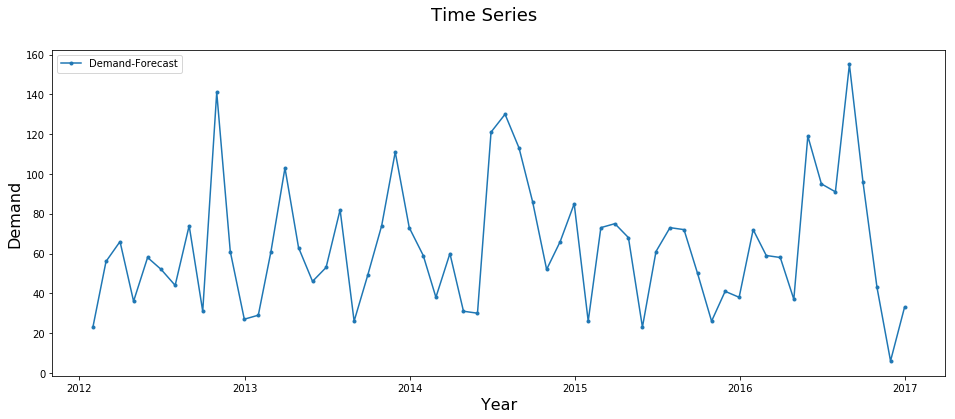

In [11]:
fig = plt.figure(figsize=(16, 6))
# line plot of observed vs predicted
plt.plot(ts, linestyle='-', marker='.', label='Demand-Forecast')
fig.suptitle(('Time Series'), fontsize=18)
plt.xlabel('Year', fontsize=16)
plt.ylabel('Demand', fontsize=16)
plt.legend(loc='best')

#### Check if series is stationary

Time series are stationary if they do not have trend or seasonal effects. When a time series is stationary and easier to model. Statistical modeling methods requires the time series to be stationary to be effective.

In [12]:
def test_stationarity(timeseries):
    
    #Determing rolling statistics
    # rolmean = pd.rolling_mean(timeseries, window=12)
    rolmean = timeseries.rolling(12).mean()
    # rolstd = pd.rolling_std(timeseries, window=12)
    rolstd = timeseries.rolling(12).std()

    fig = plt.figure(figsize=(16, 6))
    #Plot rolling statistics:
    orig = plt.plot(timeseries, color='blue',label='Original')
    mean = plt.plot(rolmean, color='red', label='Rolling Mean')
    std = plt.plot(rolstd, color='black', label='Rolling Std')
    plt.legend(loc='best')
    plt.xlabel('Year', fontsize=16)
    plt.ylabel('Demand', fontsize=16)
    plt.title('Rolling Mean & Standard Deviation', fontsize=18)
    plt.show(block=False)
    
    #Perform Dickey-Fuller test:
    print 'Results of Dickey-Fuller Test:'
    dftest = adfuller(timeseries, autolag='AIC')
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
    for key,value in dftest[4].items():
        dfoutput['Critical Value (%s)'%key] = value
    print dfoutput

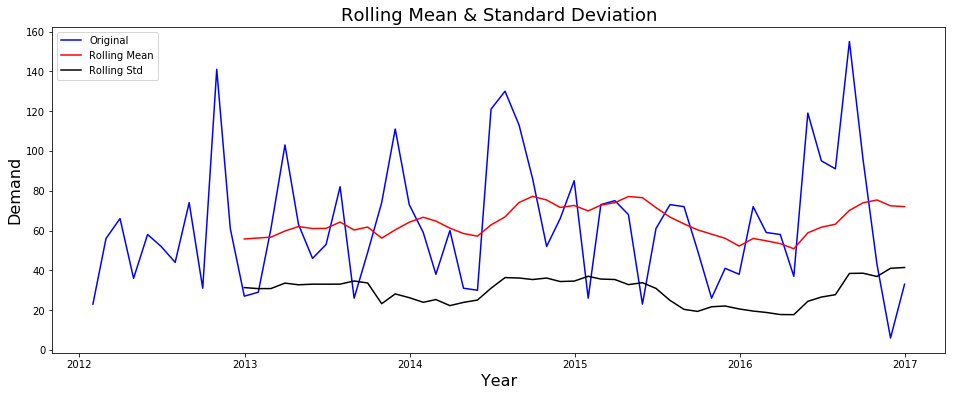

Results of Dickey-Fuller Test:
Test Statistic                 -5.034089
p-value                         0.000019
#Lags Used                      1.000000
Number of Observations Used    58.000000
Critical Value (5%)            -2.912837
Critical Value (1%)            -3.548494
Critical Value (10%)           -2.594129
dtype: float64


In [13]:
plt.figure(figsize=(16, 6))
test_stationarity(ts)

#### Moving average

Rolling means (or moving averages) are generally used to smooth out short-term fluctuations in time series data and highlight long-term trends.

moving_avg: 
Date
2012-01-31   NaN
2012-02-29   NaN
2012-03-31   NaN
2012-04-30   NaN
2012-05-31   NaN
Freq: M, Name: Order_Demand, dtype: float64


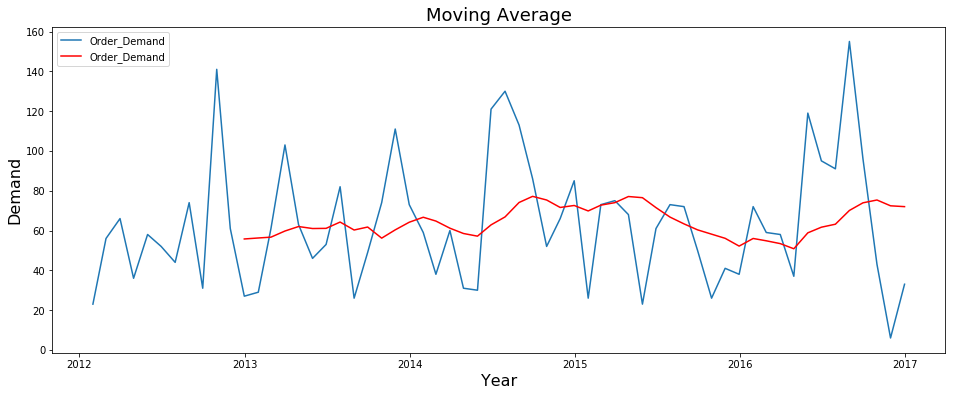

In [14]:
# Moving average plot
moving_avg = ts.rolling(12).mean()
print("moving_avg: \n{}".format(moving_avg.head()))
fig = plt.figure(figsize=(16, 6))
plt.plot(ts)
plt.plot(moving_avg, color='red')
plt.title('Moving Average', fontsize=18)
plt.legend(loc='best')
plt.xlabel('Year', fontsize=16)
plt.ylabel('Demand', fontsize=16)


In [15]:
ts_moving_avg_diff = ts - moving_avg
print("ts_moving_avg_diff: \n{}".format(ts_moving_avg_diff.head(15)))

ts_moving_avg_diff: 
Date
2012-01-31          NaN
2012-02-29          NaN
2012-03-31          NaN
2012-04-30          NaN
2012-05-31          NaN
2012-06-30          NaN
2012-07-31          NaN
2012-08-31          NaN
2012-09-30          NaN
2012-10-31          NaN
2012-11-30          NaN
2012-12-31   -28.750000
2013-01-31   -27.250000
2013-02-28     4.333333
2013-03-31    43.250000
Freq: M, Name: Order_Demand, dtype: float64


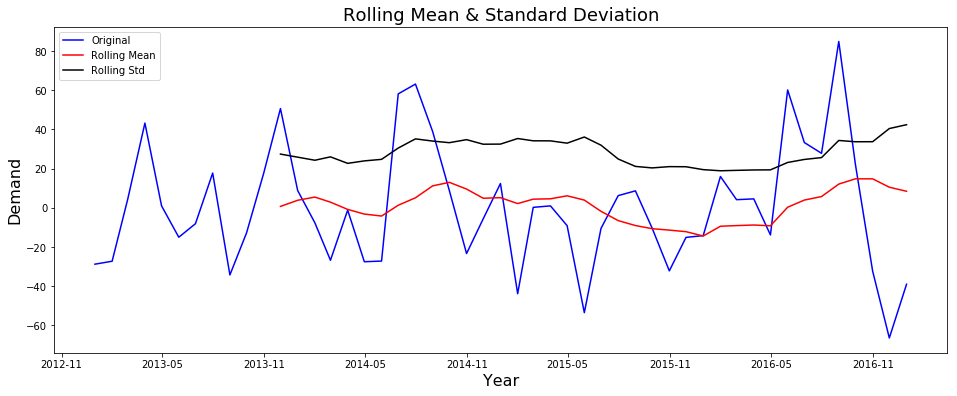

Results of Dickey-Fuller Test:
Test Statistic                 -4.330093
p-value                         0.000394
#Lags Used                      0.000000
Number of Observations Used    48.000000
Critical Value (5%)            -2.923954
Critical Value (1%)            -3.574589
Critical Value (10%)           -2.600039
dtype: float64


In [16]:
# Lets drop these NaN values and check the plots to test stationarity
plt.figure(figsize=(16, 6))
ts_moving_avg_diff.dropna(inplace=True)
test_stationarity(ts_moving_avg_diff)

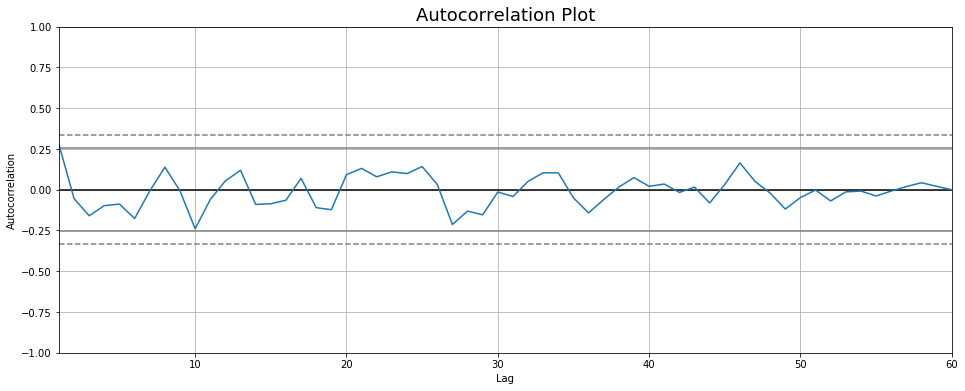

In [17]:
fig = plt.figure(figsize=(16, 6))
pd.plotting.autocorrelation_plot(ts);
plt.title('Autocorrelation Plot', fontsize=18)


### Eliminating Trend and Seasonality

#### Differencing

In [18]:
# print("ts.shift(): \n{}".format(ts.shift()))
ts_diff = ts - ts.shift()
print("ts_diff: \n{}".format(ts_diff.head(15)))

ts_diff: 
Date
2012-01-31      NaN
2012-02-29     33.0
2012-03-31     10.0
2012-04-30    -30.0
2012-05-31     22.0
2012-06-30     -6.0
2012-07-31     -8.0
2012-08-31     30.0
2012-09-30    -43.0
2012-10-31    110.0
2012-11-30    -80.0
2012-12-31    -34.0
2013-01-31      2.0
2013-02-28     32.0
2013-03-31     42.0
Freq: M, Name: Order_Demand, dtype: float64


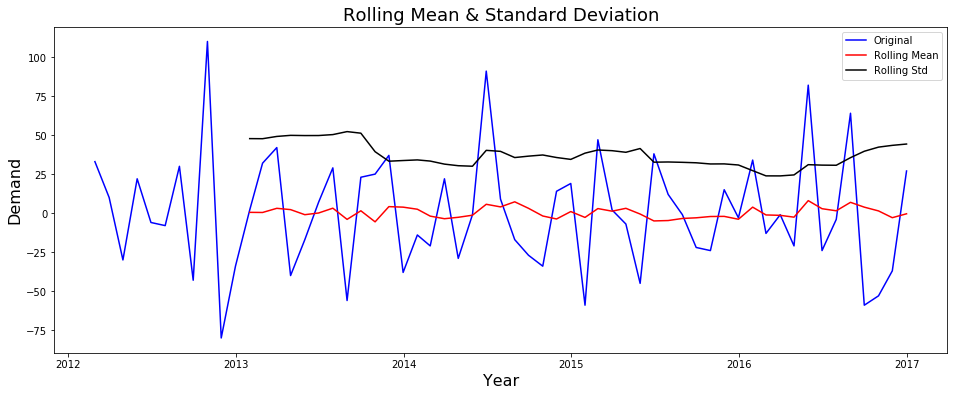

Results of Dickey-Fuller Test:
Test Statistic                 -3.640858
p-value                         0.005026
#Lags Used                      9.000000
Number of Observations Used    49.000000
Critical Value (5%)            -2.922629
Critical Value (1%)            -3.571472
Critical Value (10%)           -2.599336
dtype: float64


In [19]:
ts_diff.dropna(inplace=True)
plt.figure(figsize=(16, 6))
test_stationarity(ts_diff)

#### Decomposing

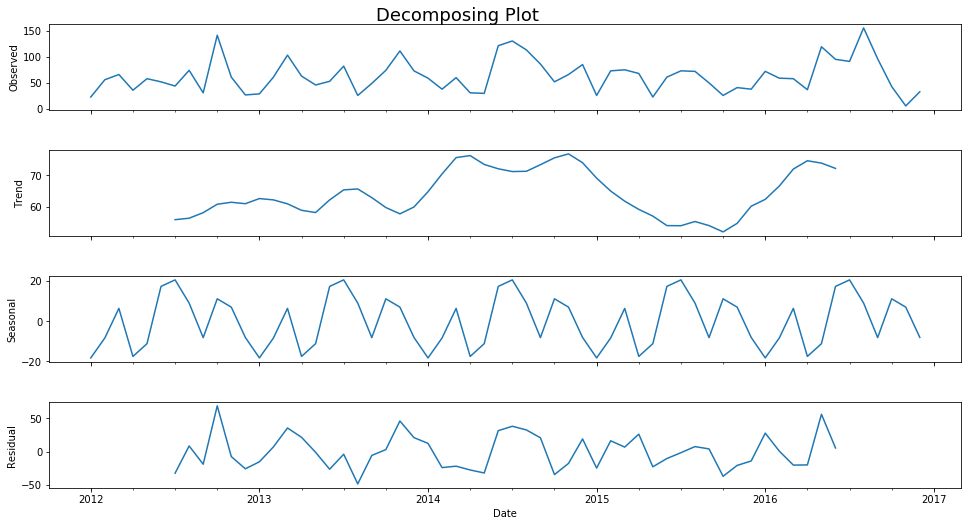

In [20]:
decomposition = seasonal_decompose(ts, freq=12);
fig = plt.figure();
fig = decomposition.plot();
fig.set_size_inches(15, 8);
fig.suptitle(('Decomposing Plot'), fontsize=18)


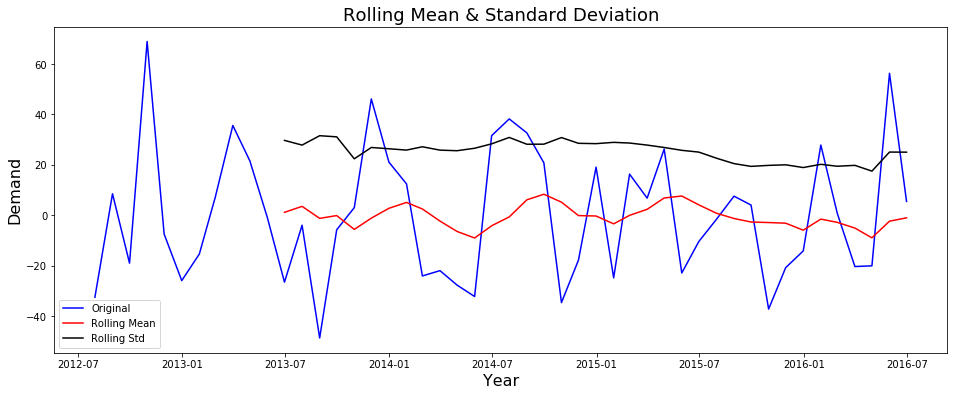

Results of Dickey-Fuller Test:
Test Statistic                 -4.671160
p-value                         0.000095
#Lags Used                      5.000000
Number of Observations Used    42.000000
Critical Value (5%)            -2.933297
Critical Value (1%)            -3.596636
Critical Value (10%)           -2.604991
dtype: float64


In [21]:
# stationarity of residuals
residual = decomposition.resid
plt.figure(figsize=(16, 6))
ts_decompose = residual
ts_decompose.dropna(inplace=True)
test_stationarity(ts_decompose)

#### Autocorrelation Function (ACF) and Partial Autocorrelation Function (PACF) Plots

* Autocorrelation Function (ACF) measures of the correlation between the the TS with a lagged version of itself. For instance at lag 5, ACF would compare series at time instant ‘t1’…’t2’ with series at instant ‘t1-5’…’t2-5’ (t1-5 and t2 being end points).

* Partial Autocorrelation Function (PACF) measures the correlation between the TS with a lagged version of itself but after eliminating the variations already explained by the intervening comparisons. Eg at lag 5, it will check the correlation but remove the effects already explained by lags 1 to 4.

In [22]:
#ACF and PACF plots:
lag_acf = acf(ts_diff, nlags=20)
lag_pacf = pacf(ts_diff, nlags=20, method='ols')

#### Plot ACF

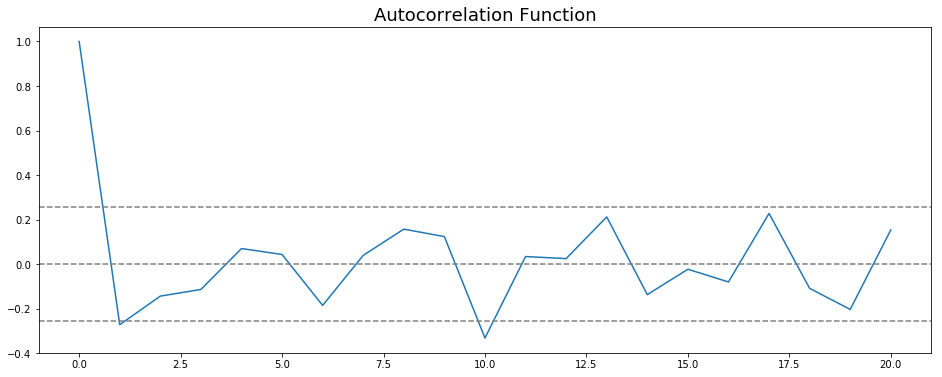

In [23]:
#Plot ACF: 
plt.figure(figsize=(16, 6))
plt.subplot() 
plt.plot(lag_acf)
plt.axhline(y=0,linestyle='--',color='gray')
plt.axhline(y=-1.96/np.sqrt(len(ts_diff)),linestyle='--',color='gray')
plt.axhline(y=1.96/np.sqrt(len(ts_diff)),linestyle='--',color='gray')
plt.title('Autocorrelation Function', fontsize=18)

#### Plot PACF

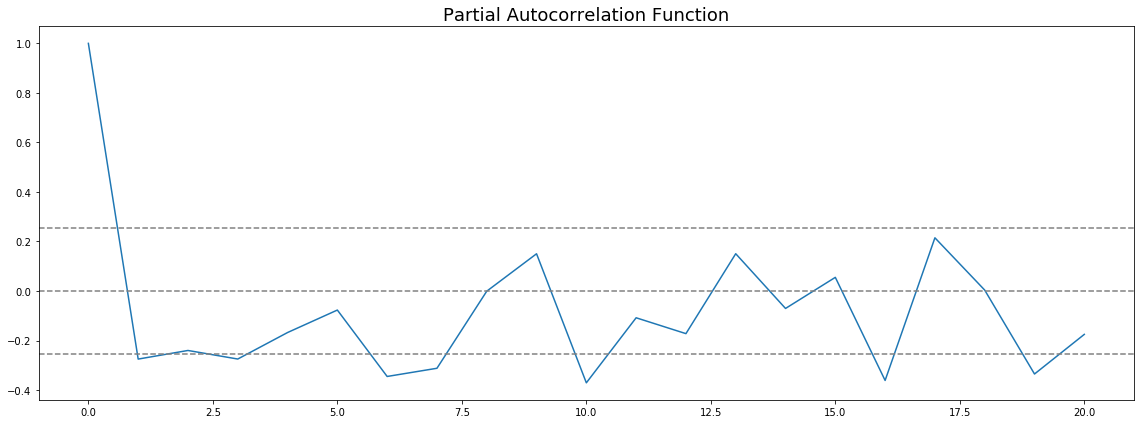

In [24]:
#Plot PACF:
fig = plt.figure(figsize=(16, 6))
plt.subplot()
plt.plot(lag_pacf)
plt.axhline(y=0,linestyle='--',color='gray')
plt.axhline(y=-1.96/np.sqrt(len(ts_diff)),linestyle='--',color='gray')
plt.axhline(y=1.96/np.sqrt(len(ts_diff)),linestyle='--',color='gray')
plt.title('Partial Autocorrelation Function', fontsize=18)
plt.tight_layout()

### Benchmark time series with ARIMA model

ARIMA is an acronym that stands for AutoRegressive Integrated Moving Average.  It provides a simple yet powerful method for making skillful time series forecasts.
*  AR: Autoregression. A model that uses the dependent relationship between an observation and some number of lagged observations.
*  I: Integrated. The use of differencing of raw observations (e.g. subtracting an observation from an observation at the previous time step) in order to make the time series stationary.
*  MA: Moving Average. A model that uses the dependency between an observation and a residual error from a moving average model applied to lagged observations.

A standard notation is used of ARIMA(p,d,q) where the parameters are substituted with integer values to quickly indicate the specific ARIMA model being used.  The parameters of the ARIMA model are defined as follows:
*  p: The number of lag observations included in the model, also called the lag order.
*  d: The number of times that the raw observations are differenced, also called the degree of differencing.
*  q: The size of the moving average window, also called the order of moving average.

When two out of the three terms are zeros, the model may be referred to based on the non-zero parameter, 
dropping "AR", "I" or "MA" from the acronym describing the model.
For example, ARIMA (1,0,0) is AR(1), ARIMA(0,1,0) is I(1), and ARIMA(0,0,1) is MA(1).  ARIMA (p, d, q)(P, D, Q)m where (p, q, d) is Non-seasonal part of the model, (P, D, Q) is seasonal part of the model, and m is number of periods per season.

In [25]:
# create Series object
y = ts
y_train = y[:'2015']
y_test = y['2016':]
print("y_train.head: \n{}".format(y_train.head()))
print("y_test.head: \n{}".format(y_test.head()))
print("y_train.values: \n{}".format(y_train.values))
print("y_test.values: \n{}".format(y_test.values))

print("Observations: {}".format(len(y)))
print("Training Observations: {}".format(len(y_train)))
print("Testing Observations: {}".format(len(y_test)))


y_train.head: 
Date
2012-01-31    23
2012-02-29    56
2012-03-31    66
2012-04-30    36
2012-05-31    58
Freq: M, Name: Order_Demand, dtype: int64
y_test.head: 
Date
2016-01-31     72
2016-02-29     59
2016-03-31     58
2016-04-30     37
2016-05-31    119
Freq: M, Name: Order_Demand, dtype: int64
y_train.values: 
[ 23  56  66  36  58  52  44  74  31 141  61  27  29  61 103  63  46  53
  82  26  49  74 111  73  59  38  60  31  30 121 130 113  86  52  66  85
  26  73  75  68  23  61  73  72  50  26  41  38]
y_test.values: 
[ 72  59  58  37 119  95  91 155  96  43   6  33]
Observations: 60
Training Observations: 48
Testing Observations: 12


In [26]:
# define the p, d and q parameters to take any value between 0 and 2
p = d = q = range(0, 3)
print("p: {}, d: {}, q: {}".format(p, d, q))

# generate all different combinations of p, d and q triplets
pdq = list(itertools.product(p, d, q))
print("pdq: \n{}".format(pdq))

# generate all different combinations of seasonal p, q and q triplets
periods_per_season = 12
seasonal_pdq = [(x[0], x[1], x[2], periods_per_season) for x in list(itertools.product(p, d, q))]
print("seasonal_pdq: \n{}".format(seasonal_pdq))


p: [0, 1, 2], d: [0, 1, 2], q: [0, 1, 2]
pdq: 
[(0, 0, 0), (0, 0, 1), (0, 0, 2), (0, 1, 0), (0, 1, 1), (0, 1, 2), (0, 2, 0), (0, 2, 1), (0, 2, 2), (1, 0, 0), (1, 0, 1), (1, 0, 2), (1, 1, 0), (1, 1, 1), (1, 1, 2), (1, 2, 0), (1, 2, 1), (1, 2, 2), (2, 0, 0), (2, 0, 1), (2, 0, 2), (2, 1, 0), (2, 1, 1), (2, 1, 2), (2, 2, 0), (2, 2, 1), (2, 2, 2)]
seasonal_pdq: 
[(0, 0, 0, 12), (0, 0, 1, 12), (0, 0, 2, 12), (0, 1, 0, 12), (0, 1, 1, 12), (0, 1, 2, 12), (0, 2, 0, 12), (0, 2, 1, 12), (0, 2, 2, 12), (1, 0, 0, 12), (1, 0, 1, 12), (1, 0, 2, 12), (1, 1, 0, 12), (1, 1, 1, 12), (1, 1, 2, 12), (1, 2, 0, 12), (1, 2, 1, 12), (1, 2, 2, 12), (2, 0, 0, 12), (2, 0, 1, 12), (2, 0, 2, 12), (2, 1, 0, 12), (2, 1, 1, 12), (2, 1, 2, 12), (2, 2, 0, 12), (2, 2, 1, 12), (2, 2, 2, 12)]


In [27]:
# Find best pdq and best seasonal pdq.
print("np.inf: {}".format(np.inf))
best_aic = np.inf
best_pdq = None
best_seasonal_pdq = None
tmp_model = None
best_mdl = None

for param in pdq:
    for param_seasonal in seasonal_pdq:
        try:
            tmp_mdl = sm.tsa.statespace.SARIMAX(y_train,
                                                order = param,
                                                seasonal_order = param_seasonal,
                                                enforce_stationarity=True,
                                                enforce_invertibility=True)
            arima_results = tmp_mdl.fit()
            # print('ARIMA{}x{}12 - AIC:{}'.format(param, param_seasonal, arima_results.aic))
            if arima_results.aic < best_aic:
                best_aic = arima_results.aic
                best_pdq = param
                best_seasonal_pdq = param_seasonal
                best_mdl = tmp_mdl
        except:
            # print("Unexpected error:", sys.exc_info()[0])
            continue
print("Best SARIMAX{}x{}12 model - AIC:{}".format(best_pdq, best_seasonal_pdq, best_aic))

np.inf: inf
Best SARIMAX(0, 2, 2)x(1, 2, 0, 12)12 model - AIC:256.028641599


In [28]:
# define SARIMAX model and fit it to the data
arima_model = sm.tsa.statespace.SARIMAX(y_train,
                                order=(best_pdq),
                                seasonal_order=(best_seasonal_pdq),
                                enforce_stationarity=True,
                                enforce_invertibility=True)
arima_results = arima_model.fit()


In [29]:
# print statistics
print("arima_results.aic: {}".format(arima_results.aic))
print("arima_results.summary: \n{}".format(arima_results.summary().tables[1]))

arima_results.aic: 256.028641599
arima_results.summary: 
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1         -1.9866      0.616     -3.225      0.001      -3.194      -0.779
ma.L2          0.9999      0.621      1.610      0.107      -0.217       2.217
ar.S.L12      -0.7922      0.188     -4.217      0.000      -1.160      -0.424
sigma2      1848.6691      0.001   2.77e+06      0.000    1848.668    1848.670


In [30]:
# print residuals
residuals = pd.DataFrame(arima_results.resid)
print("residuals: \n{}".format(residuals.describe()))

residuals: 
                0
count   48.000000
mean    -2.777890
std     92.894524
min   -222.232050
25%    -54.320200
50%     -6.224766
75%     43.828784
max    290.922024


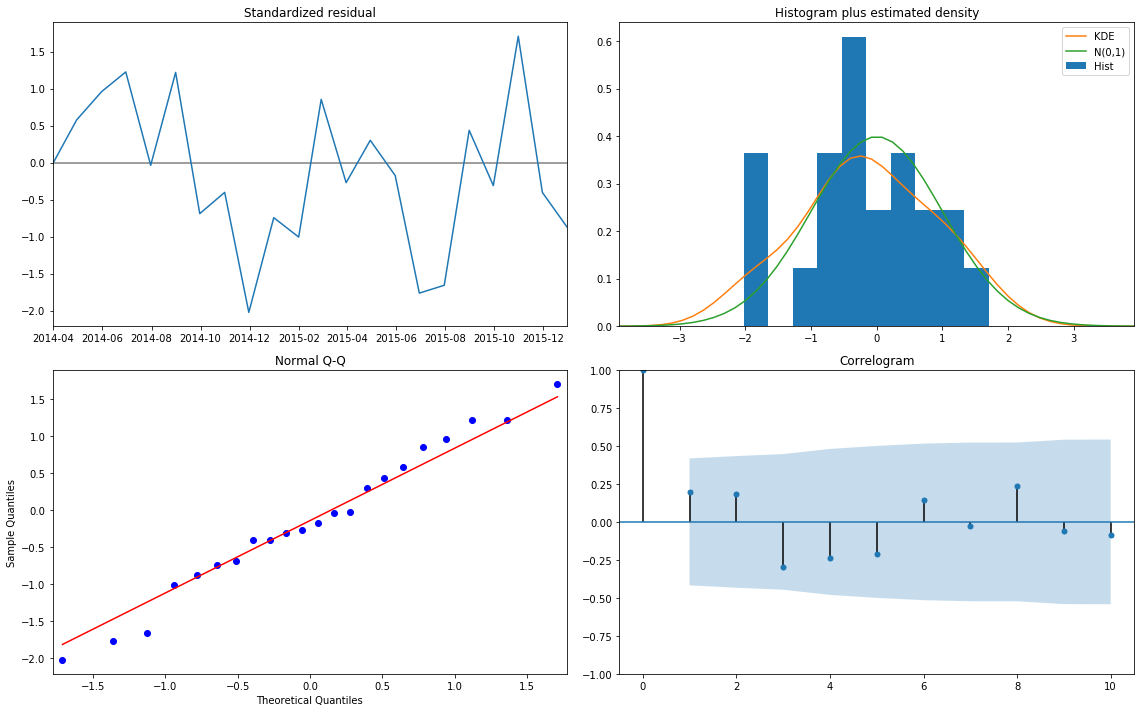

In [31]:
# Plot arima diagnpstics
arima_results.plot_diagnostics(figsize=(16, 10));
plt.tight_layout();

### One-step ahead prediction

MSE: 11502.32, RMSE: 107.25


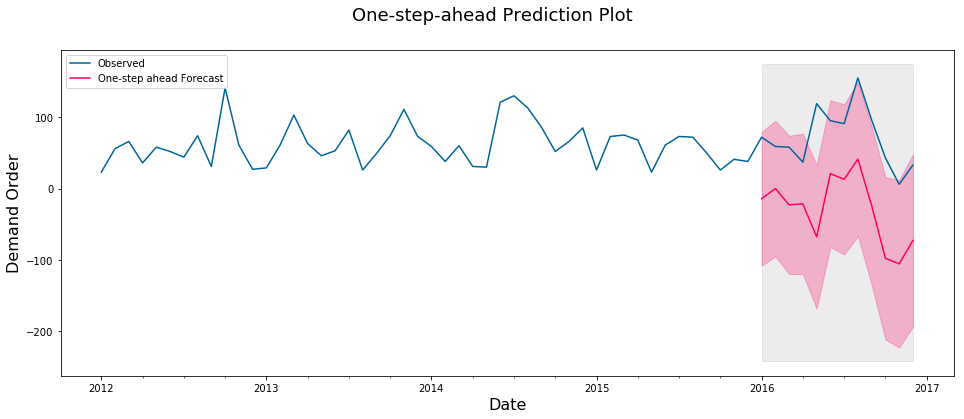

In [32]:
# predict one-step ahead forecasts
pred_one_step = arima_results.get_prediction(start=pd.to_datetime('2016-01-31'), 
                          end=pd.to_datetime('2016-12-31'),
                          dynamic=True)
pred_one_step_ci = pred_one_step.conf_int()

# plot time series and out of sample prediction
fig = plt.figure(figsize=(16, 6))
ax = y['2011':].plot(label='Observed', color='#006699')
pred_one_step.predicted_mean.plot(ax=ax, label='One-step ahead Forecast', color='#ff0066')
ax.fill_between(pred_one_step_ci.index,
                pred_one_step_ci.iloc[:, 0],
                pred_one_step_ci.iloc[:, 1], color='#ff0066', alpha=.25)
ax.fill_betweenx(ax.get_ylim(), pd.to_datetime('2016-01-31'), y.index[-1], alpha=.15, zorder=-1, color='grey')
fig.suptitle('One-step-ahead Prediction Plot', fontsize=18)
ax.set_xlabel('Date', fontsize=16)
ax.set_ylabel('Demand Order', fontsize=16)
plt.legend(loc='best')
plt.savefig('one_step_ahead_pred.png')

# extract the predicted and true values of our time series
y_hat_one_step = pred_one_step.predicted_mean
y_true = y['2016-01-31':]

# compute the mean square error
mse_one_step = ((y_true - y_hat_one_step) ** 2).mean()
rmse_one_step = math.sqrt(mse_one_step)
print('MSE: %.2f, RMSE: %.2f' %(mse_one_step, rmse_one_step))

### Out-of-sample prediction

MSE: 11502.32, RMSE: 107.25


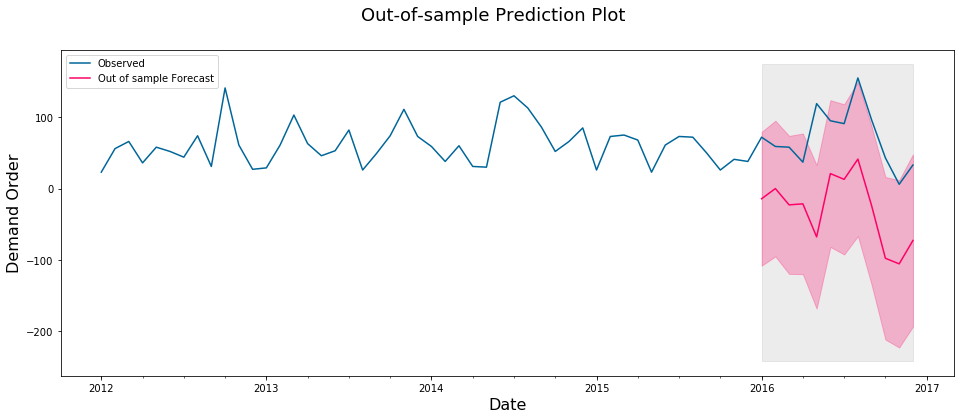

In [33]:
# predict Dynamic and find confidence bounds
pred_out_sample = arima_results.get_prediction(start=pd.to_datetime('2016-01-31'), 
                          end=pd.to_datetime('2016-12-31'),
                          dynamic=False, full_results=True)
pred_out_sample_ci = pred_out_sample.conf_int()

# plot time series and dynamic prediction
fig = plt.figure(figsize=(16, 6))
ax = y['2011':].plot(label='Observed', color='#006699')
pred_out_sample.predicted_mean.plot(ax=ax, label='Out of sample Forecast', color='#ff0066')
ax.fill_between(pred_out_sample_ci.index,
                pred_out_sample_ci.iloc[:, 0],
                pred_out_sample_ci.iloc[:, 1], color='#ff0066', alpha=.25)
ax.fill_betweenx(ax.get_ylim(), pd.to_datetime('2016-01-31'), y.index[-1], alpha=.15, zorder=-1, color='grey')
fig.suptitle('Out-of-sample Prediction Plot', fontsize=18)
ax.set_xlabel('Date', fontsize=16)
ax.set_ylabel('Demand Order', fontsize=16)
plt.legend(loc='best')
plt.savefig('Out_of_sample_pred.png')

# extract the predicted and true values of our time series
y_hat_out_sample = pred_out_sample.predicted_mean
y_true = y['2016-01-31':]

# compute the mean square error
mse_out_sample = ((y_true - y_hat_out_sample) ** 2).mean()
rmse_out_sample = math.sqrt(mse_out_sample)
print('MSE: %.2f, RMSE: %.2f' %(mse_out_sample, rmse_out_sample))

### Long-term Forecasting

In [34]:
# Find best pdq and best seasonal pdq.
print("np.inf: {}".format(np.inf))
best_aic = np.inf
best_pdq = None
best_seasonal_pdq = None
tmp_model = None
best_mdl = None

for param in pdq:
    for param_seasonal in seasonal_pdq:
        try:
            tmp_mdl = sm.tsa.statespace.SARIMAX(y,
                                                order = param,
                                                seasonal_order = param_seasonal,
                                                enforce_stationarity=True,
                                                enforce_invertibility=True)
            arima_results = tmp_mdl.fit()
            # print('ARIMA{}x{}12 - AIC:{}'.format(param, param_seasonal, arima_results.aic))
            if arima_results.aic < best_aic:
                best_aic = arima_results.aic
                best_pdq = param
                best_seasonal_pdq = param_seasonal
                best_mdl = tmp_mdl
        except:
            # print("Unexpected error:", sys.exc_info()[0])
            continue
print("Long Term Best SARIMAX{}x{}12 model - AIC:{}".format(best_pdq, best_seasonal_pdq, best_aic))

np.inf: inf
Long Term Best SARIMAX(1, 2, 2)x(2, 2, 0, 12)12 model - AIC:383.25846632


In [35]:
# define SARIMAX model and fit it to the data
arima_model_lt = sm.tsa.statespace.SARIMAX(y,
                                order=(best_pdq),
                                seasonal_order=(best_seasonal_pdq),
                                enforce_stationarity=True,
                                enforce_invertibility=True)
arima_results_lt = arima_model_lt.fit()

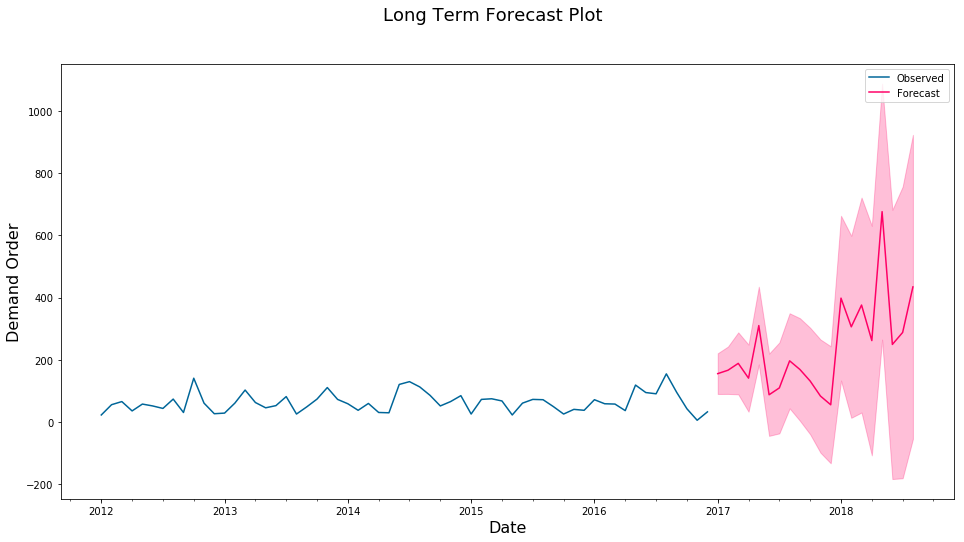

In [36]:
# get forecast for given variable numFutValPred ahead in future
numFutValPred = 20
pred_long_term = arima_results_lt.get_forecast(steps=numFutValPred)

# get confidence intervals of forecasts
pred_long_term_ci = pred_long_term.conf_int()

# plot time series and long-term forecast
fig = plt.figure(figsize=(16, 6))
ax = y.plot(label='Observed', figsize=(16, 8), color='#006699');
pred_long_term.predicted_mean.plot(ax=ax, label='Forecast', color='#ff0066');
ax.fill_between(pred_long_term_ci.index,
                pred_long_term_ci.iloc[:, 0],
                pred_long_term_ci.iloc[:, 1], color='#ff0066', alpha=.25);
fig.suptitle('Long Term Forecast Plot', fontsize=18)
ax.set_xlabel('Date', fontsize=16);
ax.set_ylabel('Demand Order', fontsize=16);
plt.legend(loc='best')
plt.savefig('long_term_pred.png')

With Arima benchmark model, we get RMSE of 107.25, which is much higher.  We should be able to decrease that by using LSTM model.

## Demand Forecast Using LSTM

In [37]:
# Transform data to be stationary and create a differenced series
raw_values = grouped_df.values
print("raw_values: \n{}".format(raw_values[:5]))


raw_values: 
[[23]
 [56]
 [66]
 [36]
 [58]]


#### Transform Time Series to Stationary

Given dataset is non-stationary because there is a structure in the data that is dependent on the time. Stationary data is easier to model and will very likely result in more skillful forecasts. The trend can be removed from the observations, then added back to forecasts later to return the prediction to the original scale and calculate a comparable error score.

In [38]:
diff = list()
interval = 1
for i in range(interval, len(raw_values)):
    value = raw_values[i] - raw_values[i - interval]
    diff.append(value)

diff_values = pd.Series(diff)
display(diff_values[:5])

0     [33]
1     [10]
2    [-30]
3     [22]
4     [-6]
dtype: object

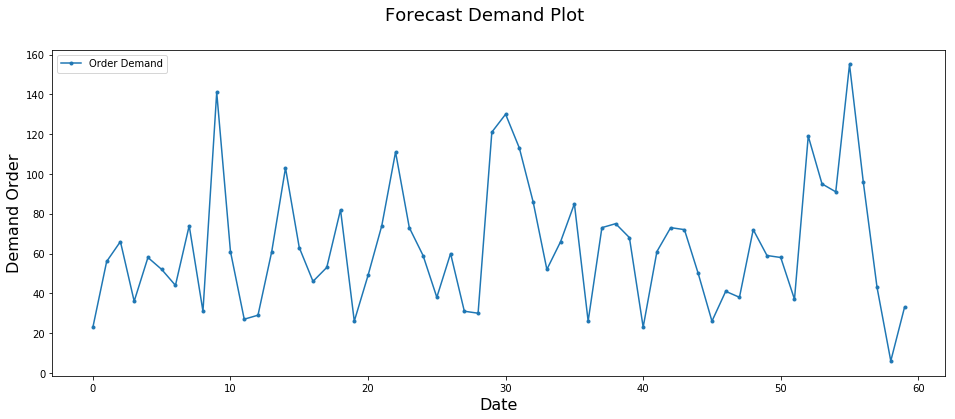

In [39]:
fig = plt.figure(figsize=(16, 6))
plt.plot(raw_values, linestyle='-', marker='.', label='Order Demand')
fig.suptitle('Forecast Demand Plot', fontsize=18)
plt.xlabel('Date', fontsize=16)
plt.ylabel('Demand Order', fontsize=16)
plt.legend(loc='best')

#### Transform Time Series to supervised learning

The LSTM model in Keras assumes that your data is divided into input (X) and output (y) components. For a time series problem, we can achieve this by using the observation from the last time step (t-1) as the input and the observation at the current time step (t) as the output. We can achieve this using the shift() function in Pandas that will push all values in a series down by a specified number places. We require a shift of 1 place, which will become the input variables. The time series as it stands will be the output variables.

In [40]:
# transform data to be supervised learning
np.random.seed(2017)
lag = 1
supervised = pd.DataFrame(diff_values)
columns = [supervised.shift(i) for i in range(1, lag+1)]
columns.append(supervised)
supervised = pd.concat(columns, axis=1)
supervised.fillna(0, inplace=True)
supervised_values = supervised.values
print("supervised_values: \n{}".format(supervised_values[:5]))

supervised_values: 
[[0 array([33])]
 [array([33]) array([10])]
 [array([10]) array([-30])]
 [array([-30]) array([22])]
 [array([22]) array([-6])]]


In [41]:
# split data into train and test-sets
np.random.seed(2017)
train, test = supervised_values[0:-12], supervised_values[-12:]
print("train: \n{}".format(train[:5]))
print("test: \n{}".format(test[:5]))


train: 
[[0 array([33])]
 [array([33]) array([10])]
 [array([10]) array([-30])]
 [array([-30]) array([22])]
 [array([22]) array([-6])]]
test: 
[[array([-3]) array([34])]
 [array([34]) array([-13])]
 [array([-13]) array([-1])]
 [array([-1]) array([-21])]
 [array([-21]) array([82])]]


In [42]:
# scale train and test data to [-1, 1]
def scale(train, test):
    # fit scaler
    scaler = MinMaxScaler(feature_range=(-1, 1))
    scaler = scaler.fit(train)
    # transform train
    train = train.reshape(train.shape[0], train.shape[1])
    train_scaled = scaler.transform(train)
    # transform test
    test = test.reshape(test.shape[0], test.shape[1])
    test_scaled = scaler.transform(test)
    return scaler, train_scaled, test_scaled


#### Transform Time Series to Scale

Like other neural networks, LSTMs expect data to be within the scale of the activation function used by the network. The default activation function for LSTMs is the hyperbolic tangent (tanh), which outputs values between -1 and 1. This is the preferred range for the time series data.

In [43]:
# transform the scale of the data
scaler, train_scaled, test_scaled = scale(train, test)
print("scaler: \n{}".format(scaler))
print("train_scaled: \n{}".format(train_scaled[:5]))
print("test_scaled: \n{}".format(test_scaled[:5]))

scaler: 
MinMaxScaler(copy=True, feature_range=(-1, 1))
train_scaled: 
[[-0.15789474  0.18947368]
 [ 0.18947368 -0.05263158]
 [-0.05263158 -0.47368421]
 [-0.47368421  0.07368421]
 [ 0.07368421 -0.22105263]]
test_scaled: 
[[-0.18947368  0.2       ]
 [ 0.2        -0.29473684]
 [-0.29473684 -0.16842105]
 [-0.16842105 -0.37894737]
 [-0.37894737  0.70526316]]


In [44]:
# fit an LSTM network to training data
def fit_lstm(train, batch_size, nb_epoch, neurons):
    X, y = train[:, 0:-1], train[:, -1]
    X = X.reshape(X.shape[0], 1, X.shape[1])
    model = Sequential()
    model.add(LSTM(neurons, batch_input_shape=(batch_size, X.shape[1], X.shape[2]), stateful=True))
    model.add(Dense(1))
    model.compile(loss='mean_squared_error', optimizer='adam')
    for i in range(nb_epoch):
        model.fit(X, y, epochs=1, batch_size=batch_size, verbose=0, shuffle=False)
        model.reset_states()
    return model


In [45]:
# fit the model
batch_size = 1
nb_epoch = 1000
neurons = 3
lstm_model = fit_lstm(train_scaled, batch_size, nb_epoch, neurons)

In [46]:
# forecast the entire training dataset to build up state for forecasting
train_reshaped = train_scaled[:, 0].reshape(len(train_scaled), 1, 1)
trainPredict = lstm_model.predict(train_reshaped, batch_size=1)
print('trainPredict shape: {}'.format(trainPredict.shape))
print(type(trainPredict))
print('trainPredict: \n{}'.format(trainPredict[:5]))

trainPredict shape: (47, 1)
<type 'numpy.ndarray'>
trainPredict: 
[[ 0.08348086]
 [-0.14861658]
 [-0.21185541]
 [ 0.04531488]
 [-0.12383103]]


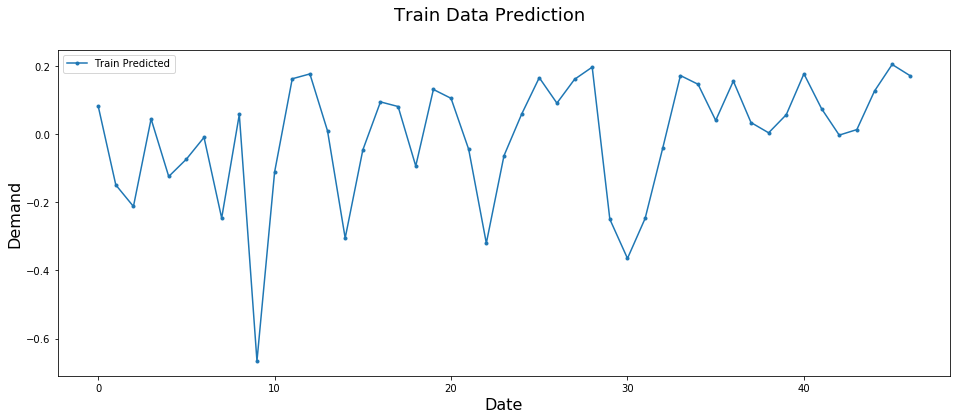

In [47]:
fig = plt.figure(figsize=(16, 6))
# line plot of observed vs predicted
plt.plot(trainPredict, linestyle='-', marker='.', label='Train Predicted')
fig.suptitle('Train Data Prediction', fontsize=18)
plt.xlabel('Date', fontsize=16)
plt.ylabel('Demand', fontsize=16)
plt.legend(loc='best')

In [48]:
# inverse scaling for a forecasted value
def invert_scale(scaler, X, value):
    new_row = [x for x in X] + [value]
    array = np.array(new_row)
    array = array.reshape(1, len(array))
    inverted = scaler.inverse_transform(array)
    return inverted[0, -1]


In [49]:
# invert differenced value
def inverse_difference(history, yhat, interval=1):
    return yhat + history[-interval]


In [50]:
# make a one-step forecast
def forecast_lstm(model, batch_size, X):
    X = X.reshape(1, 1, len(X))
    yhat = model.predict(X, batch_size=batch_size)
    return yhat[0,0]


#### Walk-forward model validation

Each time step of the test dataset will be walked one at a time. A model will be used to make a forecast for the time step, then the actual expected value from the test set will be taken and made available to the model for the forecast on the next time step.

In [51]:
# walk-forward validation on the test data
expected_vals = list()
predictions = list()
for i in range(len(test_scaled)):
    # make one-step forecast
    X, y = test_scaled[i, 0:-1], test_scaled[i, -1]
    yhat = forecast_lstm(lstm_model, 1, X)
    # invert scaling
    yhat = invert_scale(scaler, X, yhat)
    # invert differencing
    yhat = inverse_difference(raw_values, yhat, len(test_scaled)+1-i)
    # store forecast
    predictions.append(yhat)
    expected = raw_values[len(train) + i + 1]
    expected_vals.append(expected.tolist())
    print('Month=%d, Predicted=%f, Expected=%f' % (i+1, yhat, expected))    

Month=1, Predicted=68.427951, Expected=72.000000
Month=2, Predicted=88.371687, Expected=59.000000
Month=3, Predicted=81.384354, Expected=58.000000
Month=4, Predicted=83.024755, Expected=37.000000
Month=5, Predicted=69.114562, Expected=119.000000
Month=6, Predicted=110.922505, Expected=95.000000
Month=7, Predicted=100.965886, Expected=91.000000
Month=8, Predicted=101.719662, Expected=155.000000
Month=9, Predicted=119.894280, Expected=96.000000
Month=10, Predicted=99.983362, Expected=43.000000
Month=11, Predicted=77.371580, Expected=6.000000
Month=12, Predicted=45.744347, Expected=33.000000


In [52]:
print('Expected= {}'.format(expected_vals))
# report performance
mse = mean_squared_error(expected_vals, predictions)
rmse = math.sqrt(mse)
print('Test MSE: %.2f, Test RMSE: %.2f' %(mse, rmse))

Expected= [[72], [59], [58], [37], [119], [95], [91], [155], [96], [43], [6], [33]]
Test MSE: 1524.59, Test RMSE: 39.05


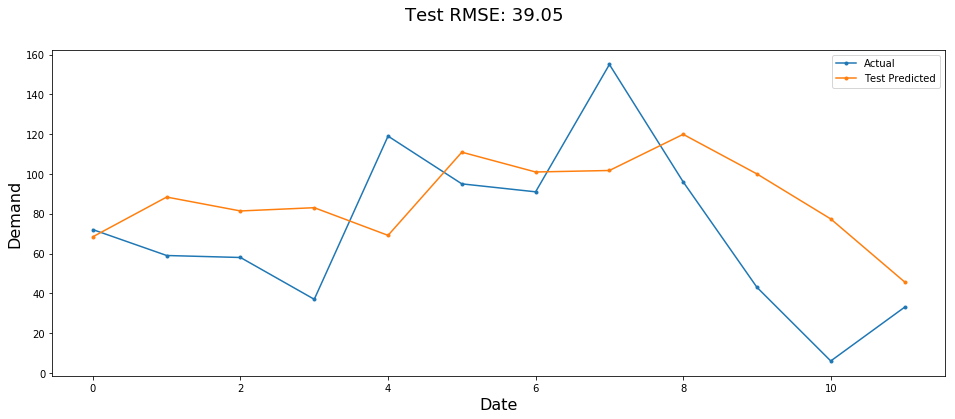

In [53]:
# line plot of observed vs predicted
fig = plt.figure(figsize=(16, 6))
plt.plot(expected_vals, linestyle='-', marker='.', label='Actual')
plt.plot(predictions, linestyle='-', marker='.', label='Test Predicted')
fig.suptitle('Test RMSE: {0:.2f}'.format(rmse), fontsize=18)
plt.xlabel('Date', fontsize=16)
plt.ylabel('Demand', fontsize=16)
plt.legend(loc='best')

In [55]:
print('ARIMA RMSE: {0:.2f}'.format(rmse_out_sample))
print('LSTM Test RMSE: {0:.2f}'.format(rmse))

ARIMA RMSE: 107.25
LSTM Test RMSE: 39.05


Above ARIMA and LSTM RMSE values clearly indicates that LSTM model has significant improvement in prediction of given time series.